# LOL esprot prediction


## 1. Giới thiệu


LOL là viết tắt của League of Legends, một tựa game thuộc thể loại đấu trường trực tuyến nhiều người chơi (MOBA) được phát triển và xuất bản bởi Riot Games. LOL được ra mắt vào năm 2009 và nhanh chóng trở thành một trong những game PC nổi tiếng và có lượng người chơi đông đảo nhất thế giới cho đến tận bây giờ.

Dự án này được xây dựng nhằm mục đích dự đoán đội chiến thắng trong một trận đấu LOL chuyên nghiệp dựa trên các thông số của của mỗi đội trong từng trận đấu tại các mùa giải khác nhau

Dữ liệu trong dự án này được lấy từ trang web tổng hợp dữ liệu các trận đấu chuyên nghiệp gol.gg

### Về model
Mô hình này được dạy với tất cả các trận đấu của mùa giải thông thường từ năm 2020 đến năm 2023 ở các khu vực lớn của trò chơi là VCS, LEC, LCS, LPL và LCK với tổng số lượng là 3553 trận. Mô hình này rất có thể sẽ được hưởng lợi từ việc bổ sung thêm nhiều trận đấu để đạt được 4000 trận.

Công cụ dự đoán sử dụng sức mạnh của đội làm mức trung bình trong toàn bộ mùa giải của họ và không tính đến các biến số như số liệu thống kê của từng cầu thủ, thành tích đối đầu của các đội hoặc tình hình hiện tại của đội (chẳng hạn như chuỗi thắng hoặc chuỗi thua đang diễn ra). Vì những lý do này, mô hình cũng sẽ đưa ra những dự đoán đáng tin cậy hơn vào cuối mùa giả bất chấp việc  ó bất kỳ sự hoán đổi đội hình đột ngột nào hoặc các sự kiện bên ngoài trò chơi khác xảy ra hay không.

Tôi đã cố gắng đạt được độ chính xác cao 70% và khả năng thu hồi 80% mà không cần trang bị quá mức, tương đương với mức mà một người theo dõi tích cực trung bình và một số nhà phân tích chuyên nghiệp nhận được, dựa trên dự đoán của IWDominate và người xem của anh ấy.

# 2.Setup

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report,accuracy_score,recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, StratifiedKFold
#from tensorflow.keras import models, layers, losses, metrics, optimizers
from sklearn.naive_bayes import GaussianNB
import pydotplus
#import graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import tree
from sklearn.metrics import confusion_matrix


plt.rcParams["figure.figsize"] = (20,10)
print(f'tensorflow version: {tf.__version__}')

tensorflow version: 2.16.1


In [3]:
df = pd.read_csv('data.csv')
df

,Game,Team 1,Score,Team 2,Week,Patch,Date,esportSS,Patch_short,Name_x,...,GD@15_y,PPG_y,NASHPG_y,NASH%_y,CSM_y,DPM_y,WPM_y,VWPM_y,WCPM_y,Season_short_y
0,APK Prince vs DragonX,DragonX,2 - 1,SeolHaeOne Prince,WEEK9,10.70,2020-04-16,lck spring 2020,10,DragonX,...,-925,-,0.67,50.5,31.2,1827,3.7,1.44,1.78,10
1,Griffin vs APK Prince,Griffin,2 - 1,SeolHaeOne Prince,WEEK2,10.20,2020-02-14,lck spring 2020,10,Griffin,...,-925,-,0.67,50.5,31.2,1827,3.7,1.44,1.78,10
2,DWG vs APK Prince,DAMWON Gaming,2 - 0,SeolHaeOne Prince,WEEK6,10.50,2020-03-28,lck spring 2020,10,DAMWON Gaming,...,-925,-,0.67,50.5,31.2,1827,3.7,1.44,1.78,10
3,T1 vs APK Prince,T1,2 - 0,SeolHaeOne Prince,WEEK6,10.50,2020-03-26,lck spring 2020,10,T1,...,-925,-,0.67,50.5,31.2,1827,3.7,1.44,1.78,10
4,GEN vs APK Prince,Gen.G eSports,2 - 0,SeolHaeOne Prince,WEEK4,10.30,2020-03-01,lck spring 2020,10,Gen.G eSports,...,-925,-,0.67,50.5,31.2,1827,3.7,1.44,1.78,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,CES vs GAM Esports,Cerberus Esports,2 - 1,GAM Esports,WEEK7,13.14,2023-08-05,vcs summer 2023,13,Cerberus Esports,...,941,6.07,0.73,62.1,34.3,2383,3.5,1.31,1.46,13
3549,Team Flash vs GAM Esports,Team Flash,2 - 0,GAM Esports,WEEK2,13.12,2023-06-29,vcs summer 2023,13,Team Flash,...,941,6.07,0.73,62.1,34.3,2383,3.5,1.31,1.46,13
3550,SGB vs GAM Esports,Saigon Buffalo,0 - 2,GAM Esports,WEEK7,13.14,2023-08-04,vcs summer 2023,13,Saigon Buffalo,...,941,6.07,0.73,62.1,34.3,2383,3.5,1.31,1.46,13
3551,Team Secret vs GAM Esports,Team Secret,0 - 2,GAM Esports,WEEK4,13.13,2023-07-15,vcs summer 2023,13,Team Secret,...,941,6.07,0.73,62.1,34.3,2383,3.5,1.31,1.46,13


# 3. Preprocessing

Trong phần này ta sẽ thực hiện xử lý dữ liệu thành một định dạng phù hợp với mô hình

- Xây dựng hàm get_sec để chuyển thời gian từ kiểu string về kiểu float (giây)
- Xây dựng hàm formatScore để chuyển chuyển score từ kiểu chuỗi thành kết quả thắng/thua nhị phân


In [4]:
def get_sec(time_str):
    m, s = time_str.split(':')
    return float(60 * int(m) + int(s))

def formatScore(score):
    if score[0] == '0' or score == '1 - 2':
        return [0, 1]
    else:
        return [1, 0]

tmpdf = df

In [5]:
df["Score"] = df["Score"].apply(lambda x: formatScore(x))

df["Game duration_x"] = df["Game duration_x"].apply(lambda x: get_sec(x))
df["Game duration_y"] = df["Game duration_y"].apply(lambda x: get_sec(x))

df["Season_y"] = df["Season_y"].apply(lambda x: str(x).replace('S', '')).astype(float)
df["Season_x"] = df["Season_x"].apply(lambda x: str(x).replace('S', '')).astype(float)

df["Win rate_x"] = df["Win rate_x"].apply(lambda x: float(x.replace("%", "")))
df["Win rate_y"] = df["Win rate_y"].apply(lambda x: float(x.replace("%", "")))

In [6]:
df['Score']

0       [1, 0]
1       [1, 0]
2       [1, 0]
3       [1, 0]
4       [1, 0]
         ...  
3548    [1, 0]
3549    [1, 0]
3550    [0, 1]
3551    [0, 1]
3552    [0, 1]
Name: Score, Length: 3553, dtype: object

- Loại bỏ các cột không cần thiết

In [7]:
df = df.drop(columns=[ 'Patch', 'Date', 'Region_y', 'Region_x', 'Game', 'Team 1', 'Team 2', 'VGPG_x','VGPG_y',
                      'Name_y', 'Name_x','Week','esportSS','Patch_short','Season_short_x','Season_short_y'])

- Loại bỏ các hàng, các cột có giá trị null

In [8]:
 # Loại bỏ tất cả các hàng có giá trị null
df.dropna(how="any", inplace=True)

# Loại bỏ tất cả các cột có giá trị null
df.dropna(axis='columns', inplace=True)  

- Định dạng lại một số cột có kiểu dữ liệu chưa phù hợp, chuyển kiểu dữ liệu của các cột đó sang float

In [9]:
# tạo một list chứa các cột có kiểu dữ liệu là object
object_columns = list(df.select_dtypes(include='object').columns)
object_columns

['Score',
 'FB%_x',
 'FT%_x',
 'HERPG_x',
 'HER%_x',
 'DRA@15_x',
 'TD@15_x',
 'GD@15_x',
 'PPG_x',
 'WPM_x',
 'VWPM_x',
 'WCPM_x',
 'FB%_y',
 'FT%_y',
 'HERPG_y',
 'HER%_y',
 'DRA@15_y',
 'TD@15_y',
 'GD@15_y',
 'PPG_y',
 'WPM_y',
 'VWPM_y',
 'WCPM_y']

In [10]:
# trong trang web gol.gg, các ô chỉ số không có giá trị sẽ được điền bằng "-". Chuyển kí tự "-" thành số thực 0 rồi định dạng lại cột đó
for column in object_columns:
    # bỏ qua cột Score
    if column != 'Score':
        df[column] = df[column].replace('-', float(0)).astype(float)


Tập dữ liệu cuối cùng có dạng như sau:

In [11]:
df

,Score,Season_x,Games_x,Win rate_x,K:D_x,GPM_x,GDM_x,Game duration_x,Kills / game_x,Deaths / game_x,...,TD@15_y,GD@15_y,PPG_y,NASHPG_y,NASH%_y,CSM_y,DPM_y,WPM_y,VWPM_y,WCPM_y
0,"[1, 0]",10.0,46,67.4,1.42,1826,167,1965.0,13.2,9.2,...,0.0,-925.0,0.00,0.67,50.5,31.2,1827,3.7,1.44,1.78
1,"[1, 0]",10.0,45,35.6,0.83,1633,-133,2043.0,8.9,10.7,...,0.0,-925.0,0.00,0.67,50.5,31.2,1827,3.7,1.44,1.78
2,"[1, 0]",10.0,43,51.2,1.01,1784,54,2011.0,11.5,11.4,...,0.0,-925.0,0.00,0.67,50.5,31.2,1827,3.7,1.44,1.78
3,"[1, 0]",10.0,44,68.2,1.50,1790,131,2051.0,11.8,7.8,...,0.0,-925.0,0.00,0.67,50.5,31.2,1827,3.7,1.44,1.78
4,"[1, 0]",10.0,44,70.5,1.59,1791,161,2014.0,12.3,7.8,...,0.0,-925.0,0.00,0.67,50.5,31.2,1827,3.7,1.44,1.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,"[1, 0]",13.0,29,48.3,1.11,1873,12,1773.0,14.9,13.5,...,0.5,941.0,6.07,0.73,62.1,34.3,2383,3.5,1.31,1.46
3549,"[1, 0]",13.0,29,41.4,0.86,1800,-88,1958.0,11.7,13.6,...,0.5,941.0,6.07,0.73,62.1,34.3,2383,3.5,1.31,1.46
3550,"[0, 1]",13.0,27,55.6,0.96,1846,-5,1778.0,13.1,13.5,...,0.5,941.0,6.07,0.73,62.1,34.3,2383,3.5,1.31,1.46
3551,"[0, 1]",13.0,26,50.0,1.00,1848,-21,1871.0,13.6,13.6,...,0.5,941.0,6.07,0.73,62.1,34.3,2383,3.5,1.31,1.46


Thực hiện chia tập dữ liệu thành train - val - test sets

In [12]:
np.array(df['Score'])
resultArray = np.stack(df['Score'], axis=0)

data = df.copy()
data = data.drop("Score", axis = 1)
labels = resultArray

#Tạo một Series mới onedLabels bằng cách lấy phần tử đầu tiên của mỗi phần tử trong cột “Score”.
onedLabels = df["Score"].apply(lambda x: x[0])

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 80% - 20%.
train_data, test_data, train_labels, test_labels = train_test_split(data, onedLabels, test_size=0.20, train_size=0.80, random_state=0, shuffle=True)

# Tiếp tục chia tập huấn luyện thành tập huấn luyện và tập xác thực.
train_data, validation_data, train_labels, validation_labels = train_test_split(train_data, train_labels, test_size=0.20, train_size=0.80, random_state=0)

train_percentage = (train_data.count()[0] / data.count()[0]).round(2) * 100
validation_percentage = (validation_data.count()[0] / data.count()[0]).round(2) * 100
test_percentage = (test_data.count()[0] / data.count()[0]).round(2) * 100

print (f"Training set: {train_percentage}% tập dữ liệu gốc")
print (f"Validation set: {validation_percentage}% tập dữ liệu gốc")
print (f"Test set: {test_percentage}% tập dữ liệu gốc")

Training set: 64.0% tập dữ liệu gốc
Validation set: 16.0% tập dữ liệu gốc
Test set: 20.0% tập dữ liệu gốc


## Trực quan hoá dữ liệu

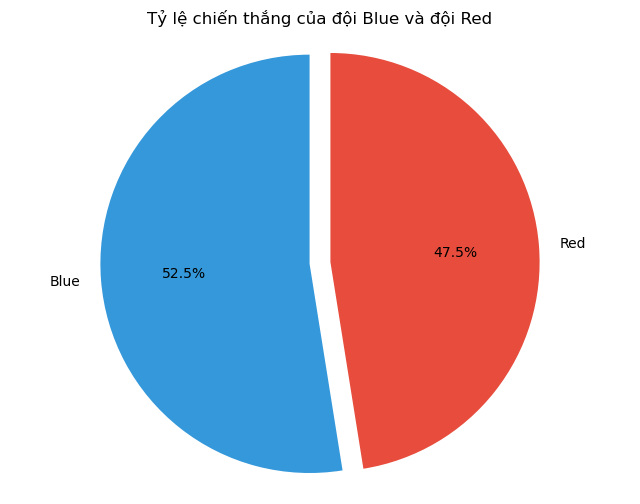

In [13]:
red, blue = np.bincount(onedLabels)
total = blue + red

blue_win_rate = round(100 * blue / total, 2)
red_win_rate = round(100 * red / total, 2)

# Tạo biểu đồ tròn
labels = ['Blue', 'Red']
sizes = [blue_win_rate, red_win_rate]
colors = ['#3498db', '#e74c3c']
explode = (0.1, 0)  # Phân tách mảnh "Blue"

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ chiến thắng của đội Blue và đội Red')
plt.axis('equal')  # Đảm bảo biểu đồ tròn

# Hiển thị biểu đồ
plt.show()

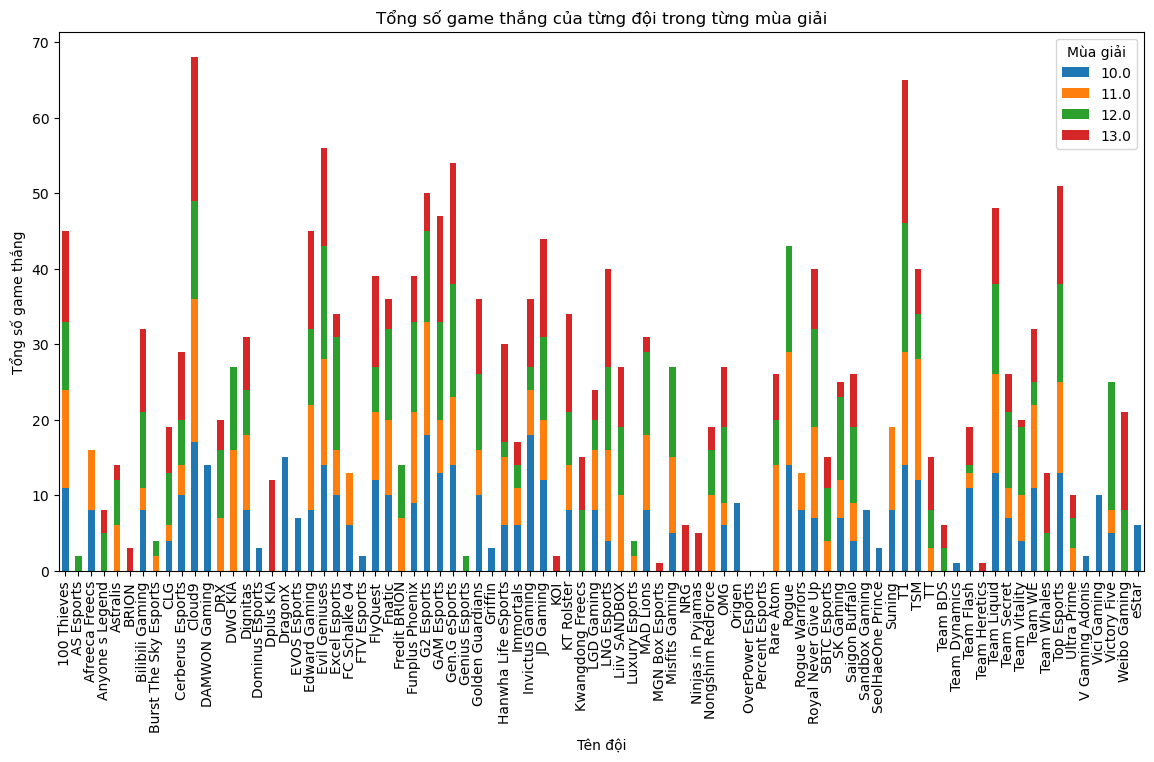

In [14]:
# Tách cột 'Score' để lấy số chiến thắng của đội x
tmpdf['Wins_x'] = tmpdf['Score'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0)

# Tính tổng số chiến thắng cho mỗi đội trong mỗi mùa giải
win_totals = tmpdf.groupby(['Name_x', 'Season_x'])['Wins_x'].sum().unstack()

# Tạo biểu đồ cột
win_totals.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Tổng số game thắng của từng đội trong từng mùa giải')
plt.xlabel('Tên đội')
plt.ylabel('Tổng số game thắng')
plt.legend(title='Mùa giải')
plt.show()

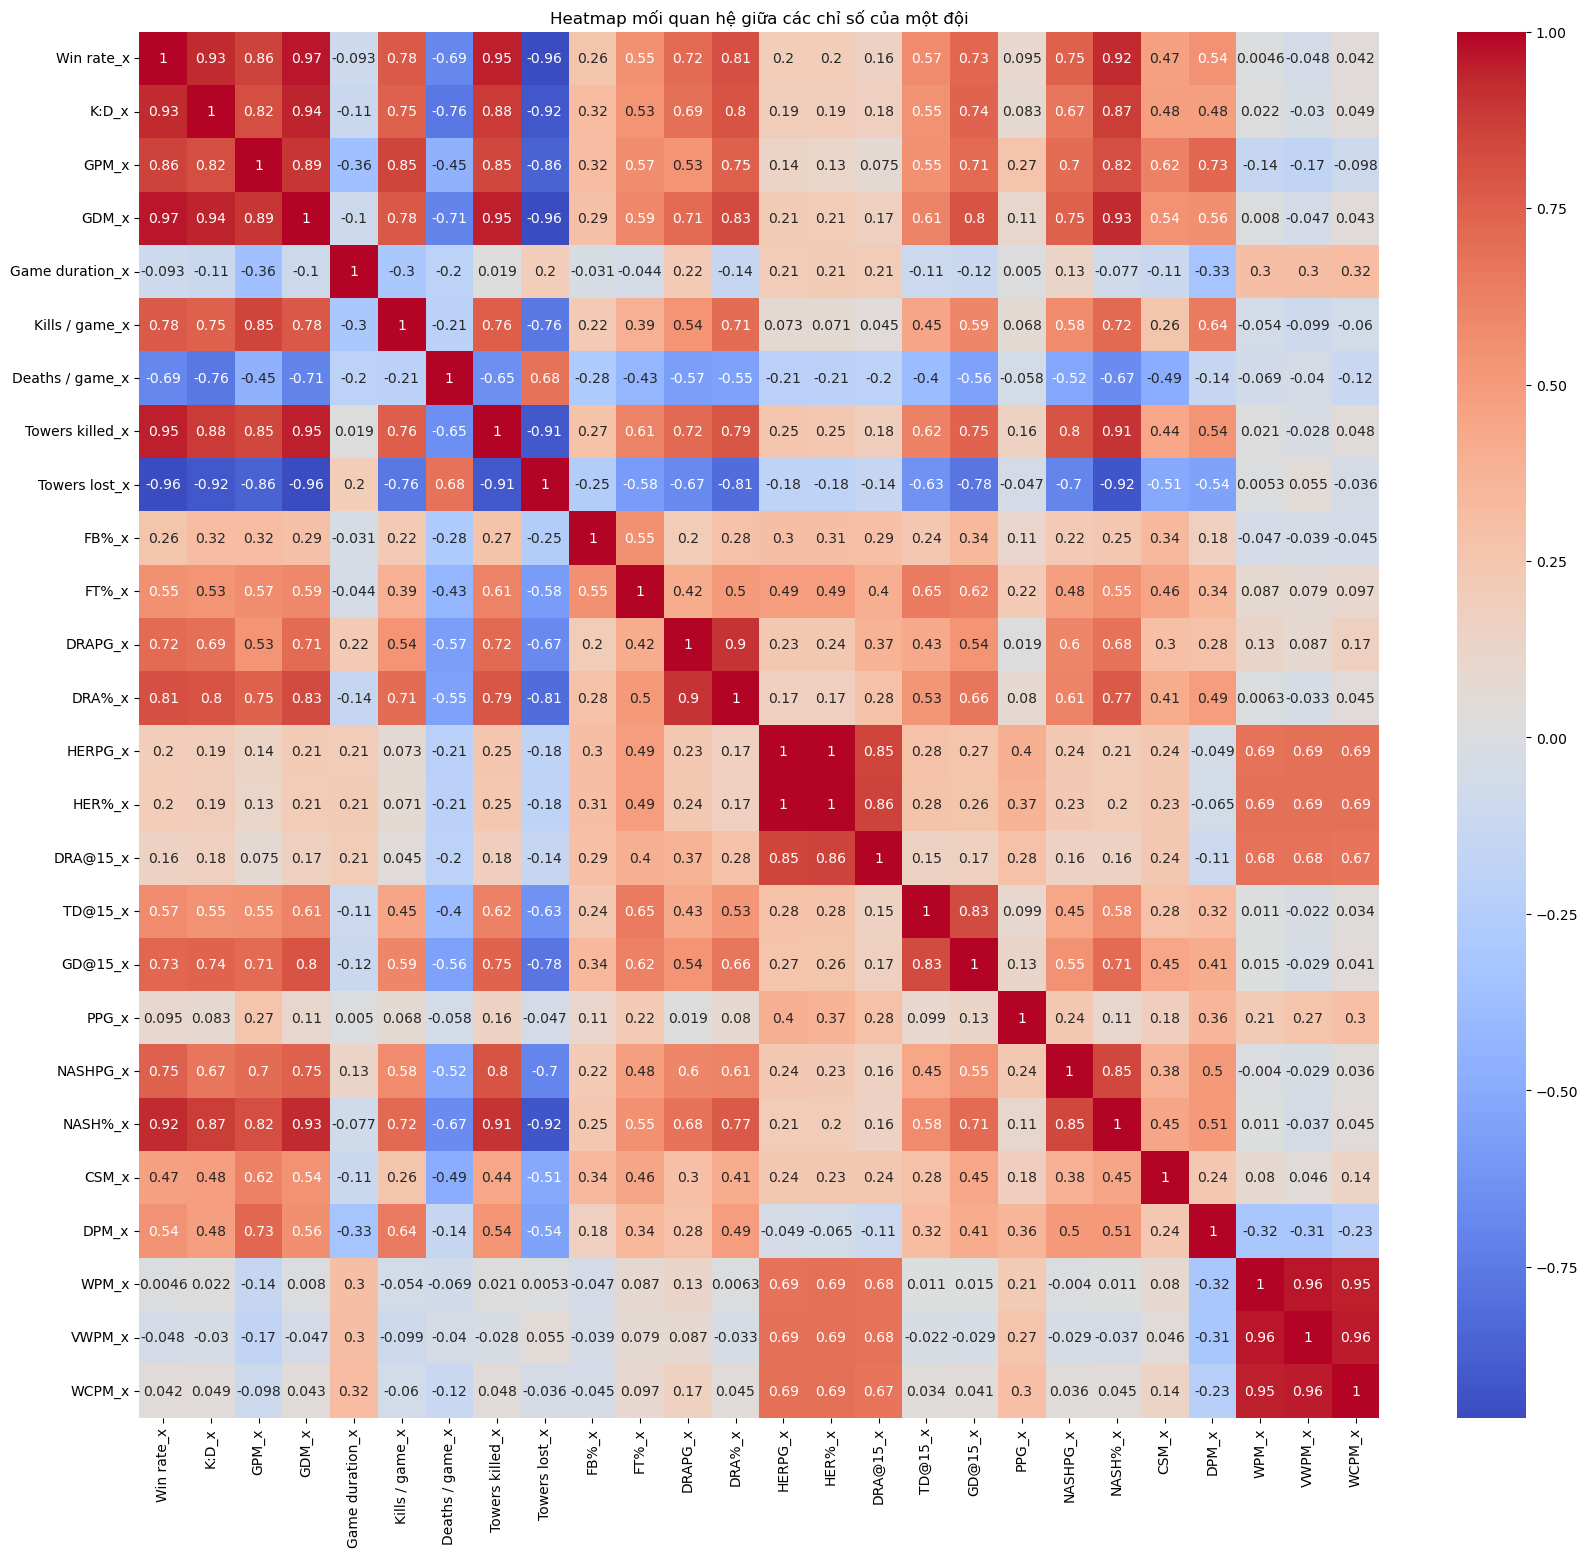

In [15]:
# Biểu đồ Heatmap cho mối quan hệ giữa các chỉ số x và y
correlation = df[['Win rate_x', 'K:D_x', 'GPM_x', 'GDM_x',
       'Game duration_x', 'Kills / game_x', 'Deaths / game_x',
       'Towers killed_x', 'Towers lost_x', 'FB%_x', 'FT%_x', 'DRAPG_x',
       'DRA%_x','HERPG_x', 'HER%_x', 'DRA@15_x', 'TD@15_x',
       'GD@15_x', 'PPG_x', 'NASHPG_x', 'NASH%_x', 'CSM_x', 'DPM_x', 'WPM_x',
       'VWPM_x', 'WCPM_x']].corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Heatmap mối quan hệ giữa các chỉ số của một đội')
plt.show()

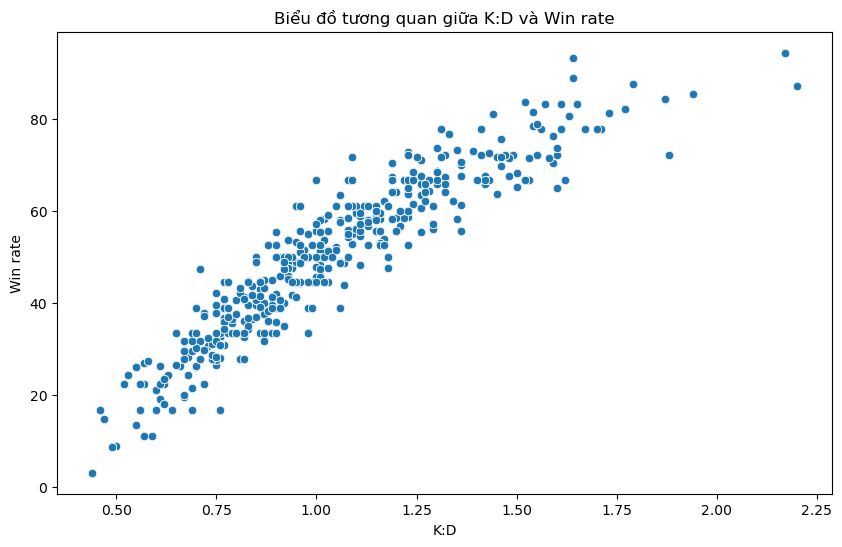

In [16]:
# Biểu đồ tương quan giữa K:D và Win rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='K:D_x', y='Win rate_x', data=df)
plt.title('Biểu đồ tương quan giữa K:D và Win rate')
plt.xlabel('K:D')
plt.ylabel('Win rate')
plt.show()

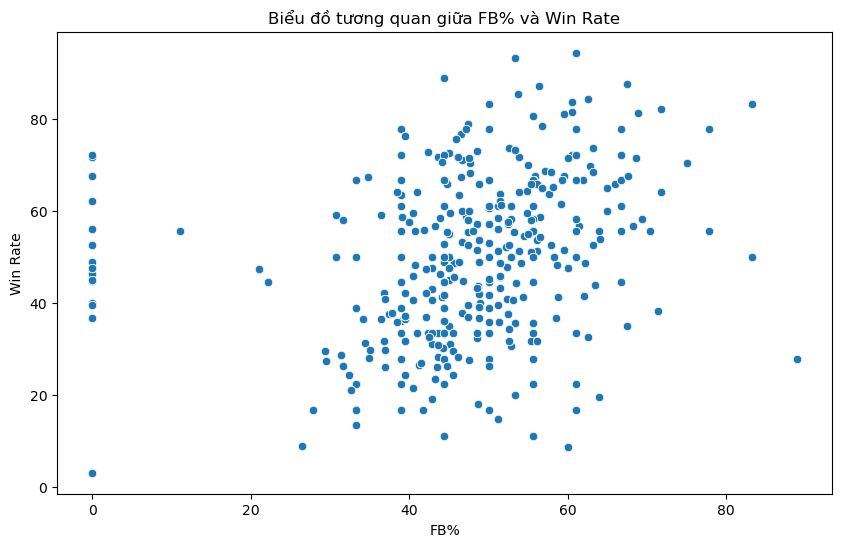

In [17]:
# Biểu đồ tương quan giữa FB% và Win Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='FB%_x', y='Win rate_x', data=df)
plt.title('Biểu đồ tương quan giữa FB% và Win Rate')
plt.xlabel('FB%')
plt.ylabel('Win Rate')
plt.show()


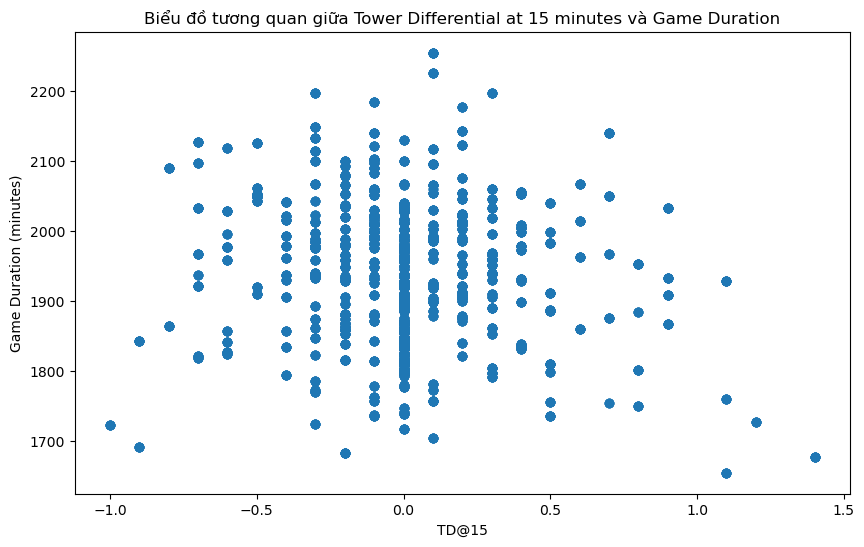

In [18]:
# Biểu đồ tương quan giữa Tower Differential at 15 minutes và Game Duration
plt.figure(figsize=(10, 6))
plt.scatter(df['TD@15_x'], df['Game duration_x'])
plt.title('Biểu đồ tương quan giữa Tower Differential at 15 minutes và Game Duration')
plt.xlabel('TD@15')
plt.ylabel('Game Duration (minutes)')
plt.show()


<Figure size 1400x700 with 0 Axes>

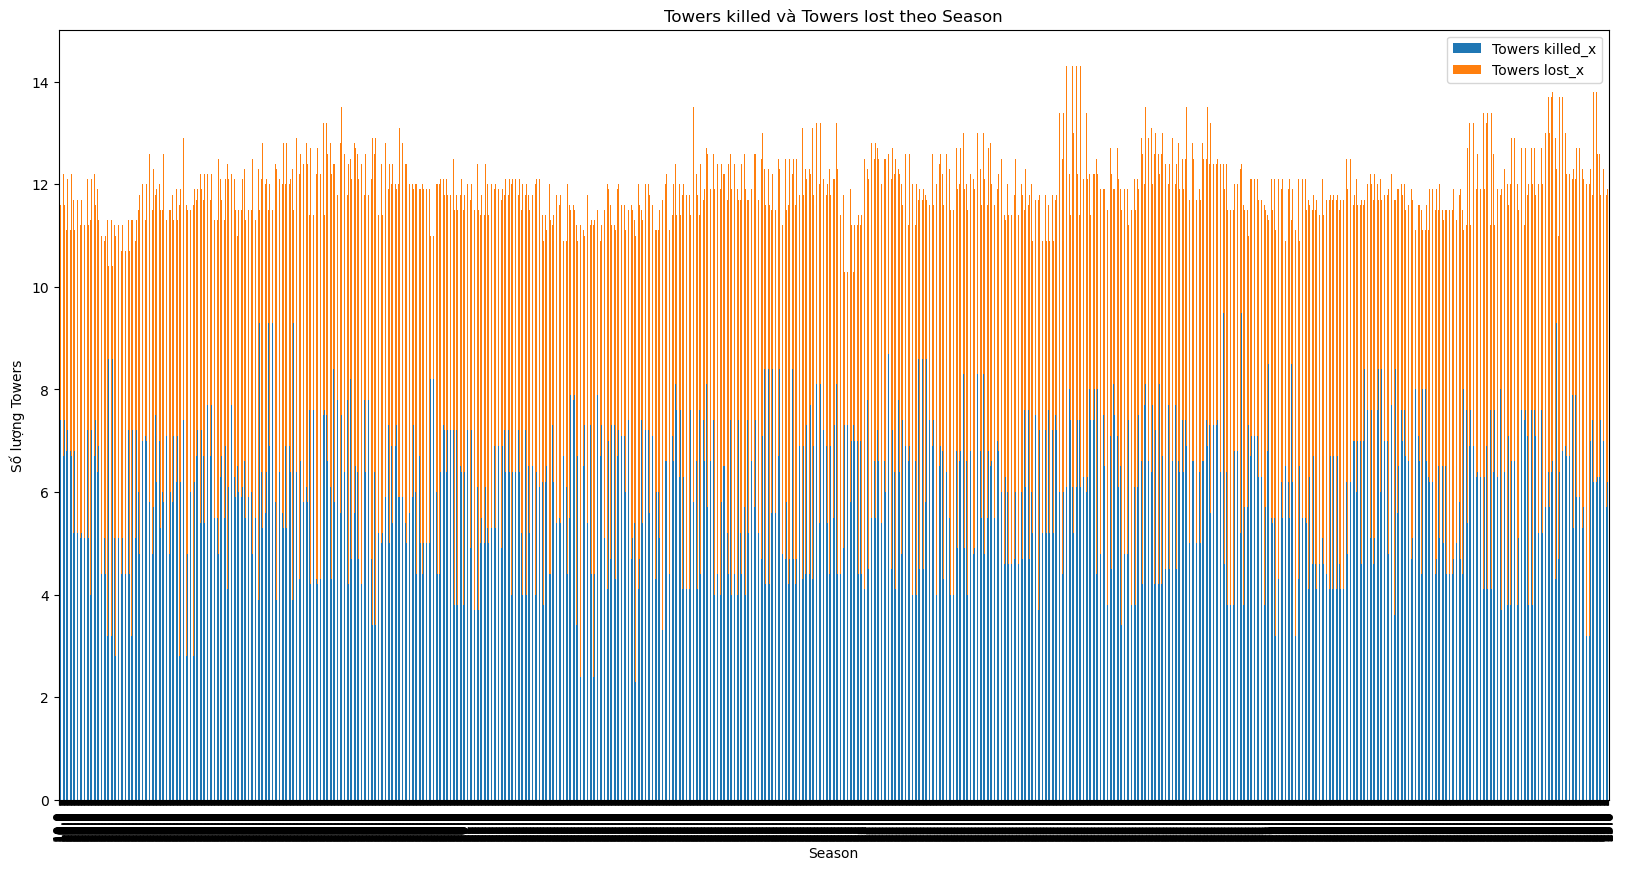

In [19]:
# Biểu đồ cột chồng cho Towers killed và Towers lost
plt.figure(figsize=(14, 7))
df.set_index('Season_x')[['Towers killed_x', 'Towers lost_x']].plot(kind='bar', stacked=True)
plt.title('Towers killed và Towers lost theo Season')
plt.xlabel('Season')
plt.ylabel('Số lượng Towers')
plt.show()


Text(0.5, 1.0, 'Phân bố GPM theo Season')

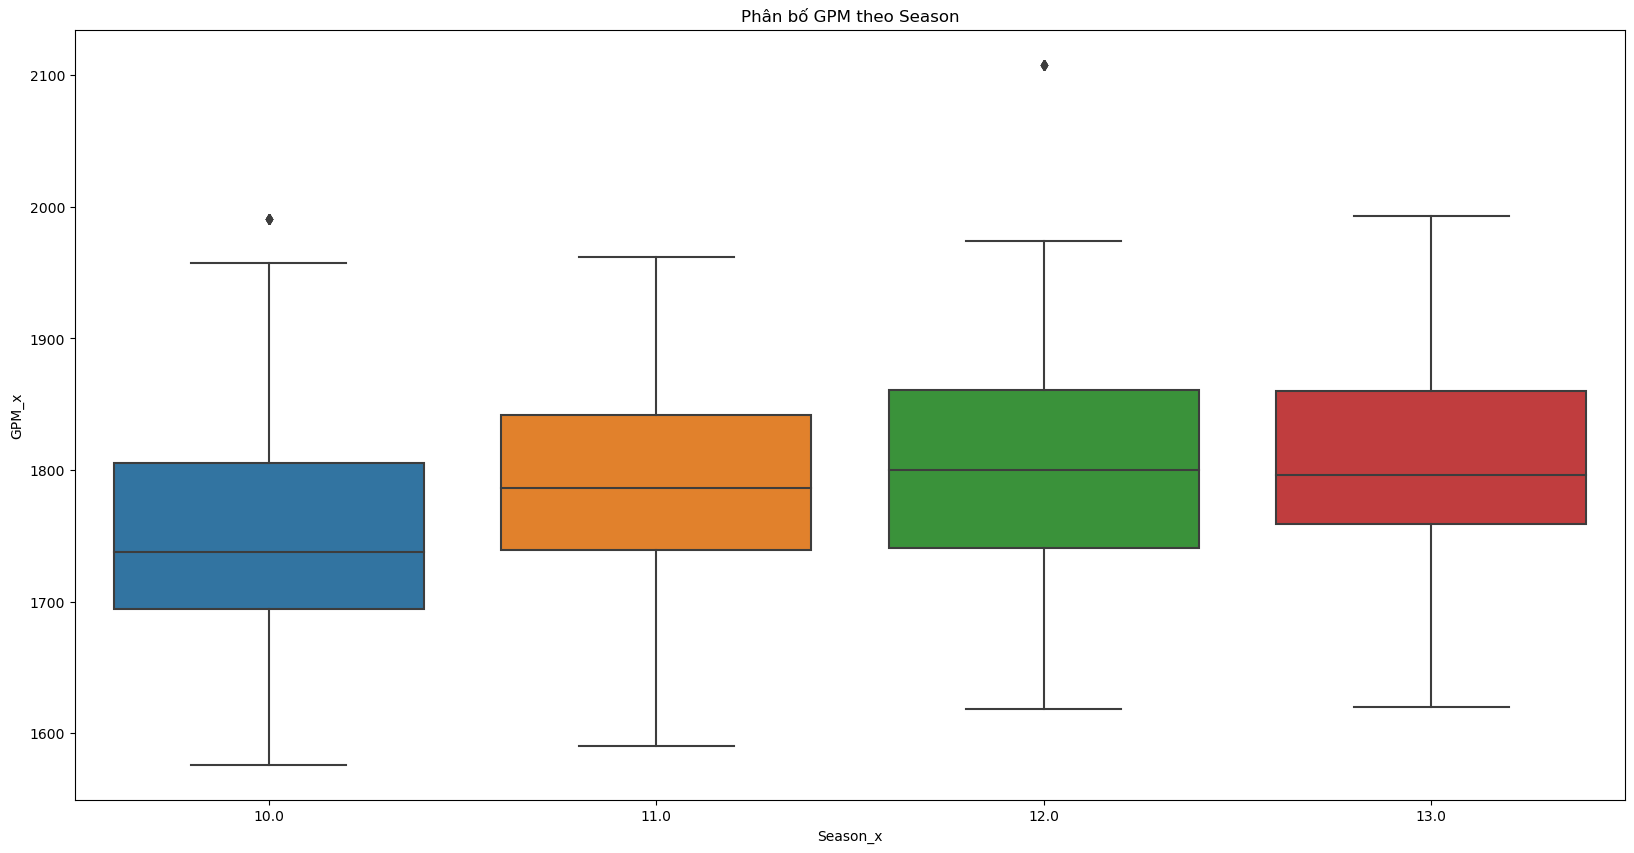

In [20]:
sns.boxplot(x='Season_x', y='GPM_x', data=df)
plt.title('Phân bố GPM theo Season')


Text(0.5, 1.0, 'Tần suất Kills/game')

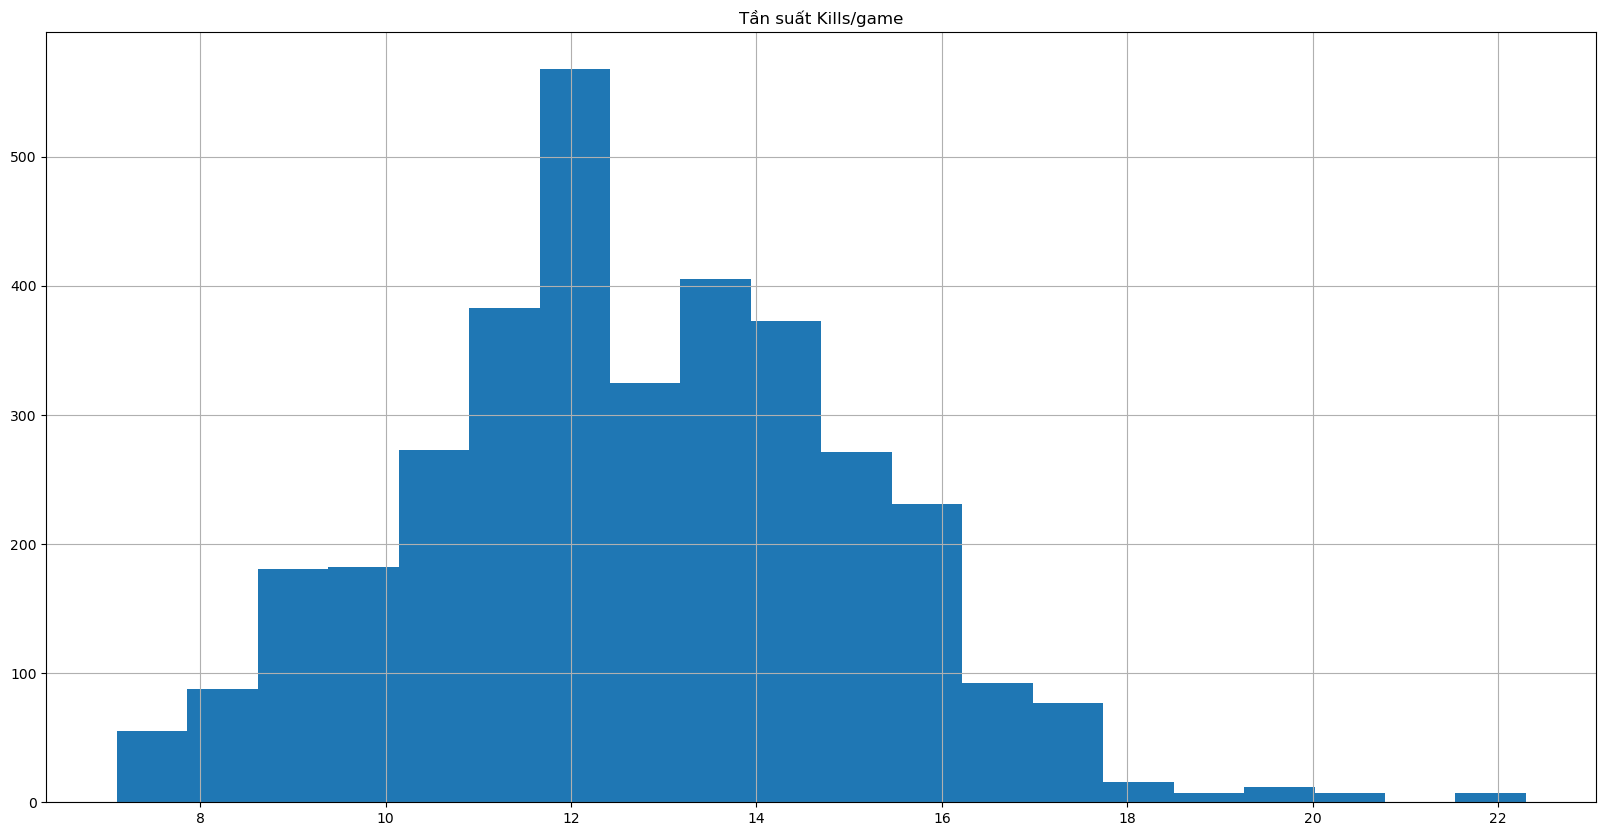

In [21]:
tmp = df['Kills / game_x']
tmp.hist(bins=20)
plt.title('Tần suất Kills/game')


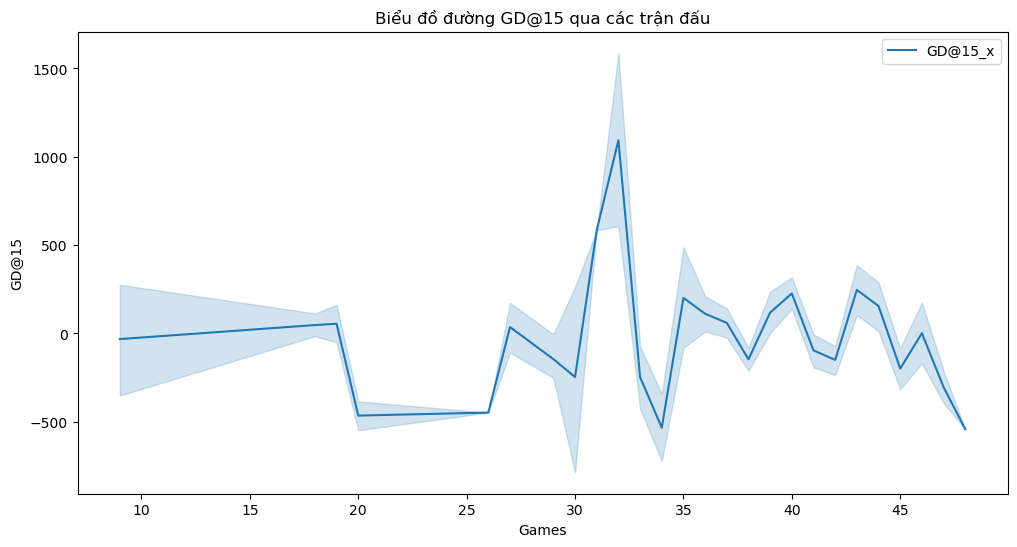

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Games_x', y='GD@15_x', data=df, label='GD@15_x')
plt.title('Biểu đồ đường GD@15 qua các trận đấu')
plt.xlabel('Games')
plt.ylabel('GD@15')
plt.show()

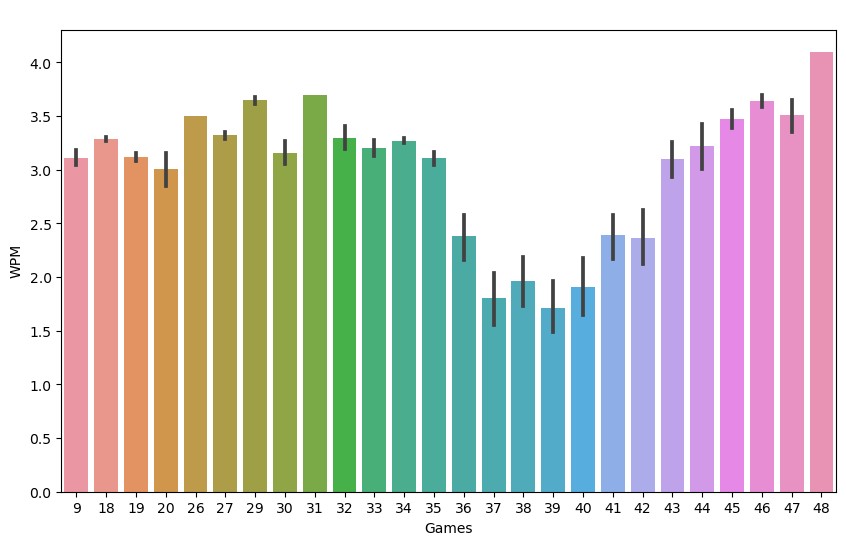

In [23]:
# Biểu đồ cột cho NASHPG_x theo Games_x
plt.figure(figsize=(10, 6))
sns.barplot(x='Games_x', y='WPM_x', data=df)
plt.title(' ')
plt.xlabel('Games')
plt.ylabel('WPM')
plt.show()

# 4. Modeling

Trong dự án này, chúng tôi đã xây dựng 4 mô hình để dự đoán kết quả của trận đấu bao gồm:
- GaussianNB
- Decision Tree
- Logistic regression
- Random Forest

Với mỗi mô hình, tôi sẽ thực hiện các công việc sau:
- Sử dụng tập huấn luyện (train_data, train_labels) để huấn luyện
- Dự đoán kết quả trên tập kiểm tra (test_data) và lưu trữ kết quả
- Đánh giá 4 hệ số: Accuracy (Độ chính xác tổng quát), Precision (Độ chính xác), Recall (Độ nhạy), F1.
- Đánh giá mô hình bằng Kiểm chứng chéo Cross (Cross Validation) trên tập huấn luyện
- vẽ confusion Matrix cho kết quả dự đoán của mô hình trên Test Set.
- Đánh giá mô hình trên tập kiểm thử và vẽ đường cong học tập (learning curve) của mô hình



#### Xây dựng các hàm cần thiết

Tạo hàm vẽ confusion_matrix


In [24]:
def draw_confusion_matrix(test_labels, predictions):
    cm = confusion_matrix(test_labels, predictions)

    #Trực quan hoá cm
    class_names = ['Thua', 'Thắng']  # Thay đổi tên lớp phù hợp với bài toán của bạn

    # Tạo heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Thêm tiêu đề và nhãn
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show() 

Tạo hàm đánh giá mô hình trên tập kiểm thử

In [25]:
def eval_val_model(model,train_data,train_labels,validation_data,validation_labels):
    # tính toán accuracy và recall trên tập huấn luyện
    predictions = model.predict(train_data)
    accuracy = accuracy_score(train_labels, predictions)
    recall = recall_score(train_labels, predictions)

    # tính toán accuracy và recall trên tập kiểm thử
    predictions = model.predict(validation_data)
    accuracy_val = accuracy_score(validation_labels, predictions)
    recall_val = recall_score(validation_labels, predictions)

    print(f"Accuracy: {round(accuracy*100,2)}% \t\t Val Accuracy: {round(accuracy_val*100,2)}%")
    print(f"Recall: {round(recall*100,2)}% \t\t\t Val Recall: {round(recall_val*100,2)}%")

Tạo hàm vẽ learning curve cho mô hình

In [26]:
def draw_learning_curve(model,train_data,train_labels):
    train_sizes, train_scores, validation_scores = learning_curve(
    model, train_data, train_labels, cv=10, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50))

    # Tính trung bình và độ lệch chuẩn của điểm số huấn luyện
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Tính trung bình và độ lệch chuẩn của điểm số kiểm thử
    validation_mean = np.mean(validation_scores, axis=1)
    validation_std = np.std(validation_scores, axis=1)

    # Vẽ đường cho điểm số huấn luyện
    plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)

    # Vẽ đường cho điểm số kiểm thử
    plt.plot(train_sizes, validation_mean, label='Cross-validation score', color='green', marker='o')
    plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.15)

    # Tạo biểu đồ
    plt.title('Learning Curves')
    plt.xlabel('Training Data Size')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='lower right')
    plt.ylim([0.5, 1.01])
    plt.grid()
    plt.show()

### 4.1 GaussianNB

GaussianNB là một thuật toán phân loại trong học máy dựa trên nguyên lý của Naive Bayes. Nó được sử dụng khi các đặc trưng (features) là liên tục và tuân theo phân phối Gaussian (phân phối chuẩn)


In [27]:
gaussianNB = GaussianNB()
gaussianNB.fit(train_data, train_labels)

predictions = gaussianNB.predict(test_data)
accuracy = accuracy_score(test_labels, predictions)
print (f"Độ chính xác được tính từ test set = {round(accuracy * 100, 2)} %")
print (classification_report(test_labels, predictions, target_names=['Blue team win', 'Red team win']))

Độ chính xác được tính từ test set = 76.09 %
               precision    recall  f1-score   support

Blue team win       0.73      0.77      0.75       327
 Red team win       0.79      0.76      0.77       384

     accuracy                           0.76       711
    macro avg       0.76      0.76      0.76       711
 weighted avg       0.76      0.76      0.76       711



Tiếp theo chúng ta sẽ đánh giá mô hình thông qua cross-validation và confution matrix

In [28]:
scores = cross_val_score(gaussianNB, train_data, train_labels, cv=5)

# In ra độ chính xác trung bình và độ lệch chuẩn
print(f'Độ chính xác trung bình: {round(scores.mean()*100,2)}% (+/- {round(scores.std() * 2 * 100,2)})')

Độ chính xác trung bình: 72.63% (+/- 3.43)


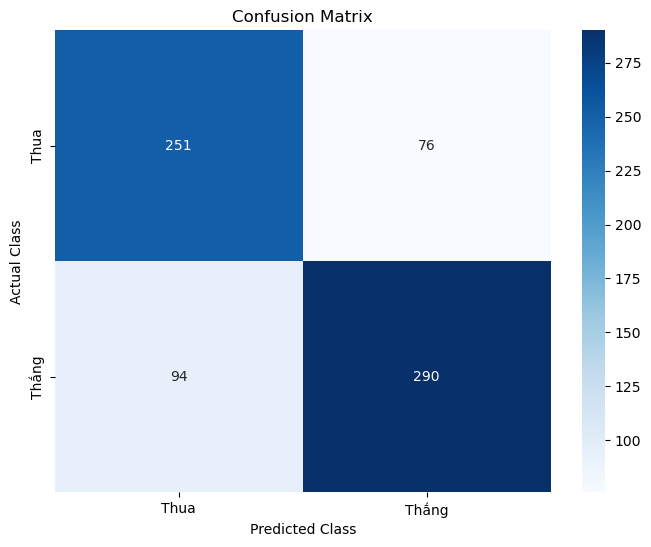

In [29]:
# vẽ confusion matrix
draw_confusion_matrix(test_labels, predictions)

Cuối cùng, chúng tôi đánh giá mô hình trên tập kiểm thử và vẽ đường cong học tập (learning curve) của mô hình để kiểm tra xem mô hình có bị overfitting hay không

In [30]:
# đánh giá mô hình trên tập kiểm thử
eval_val_model(gaussianNB,train_data,train_labels,validation_data,validation_labels)

Accuracy: 72.94% 		 Val Accuracy: 77.33%
Recall: 72.71% 			 Val Recall: 75.26%


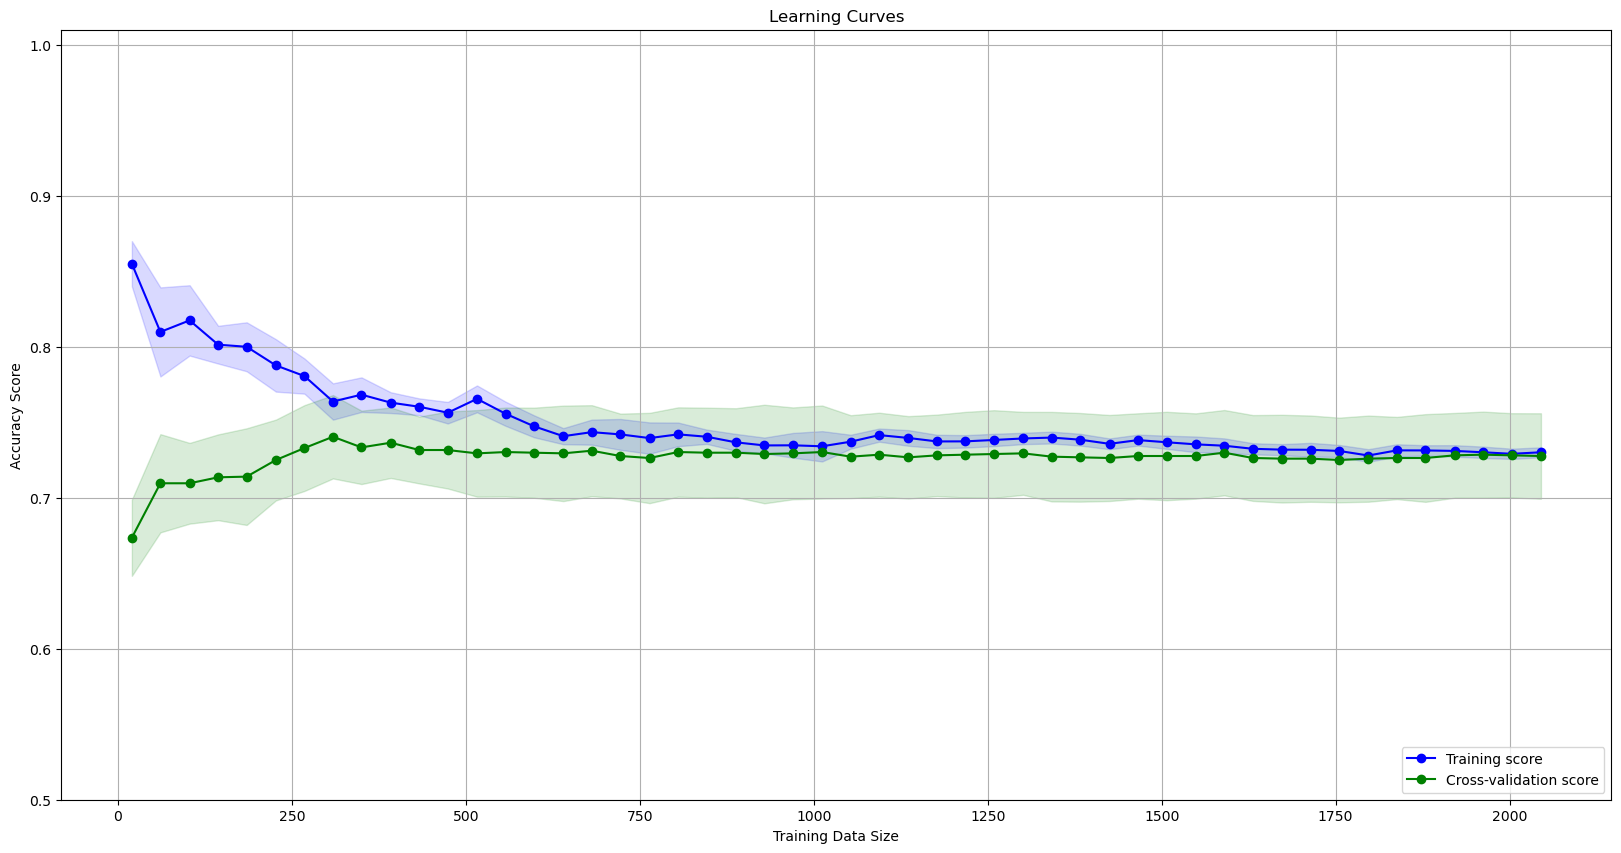

In [31]:
# vẽ learning curve
draw_learning_curve(gaussianNB, train_data, train_labels)

GaussianNB dường như rất phù hợp với tập dữ liệu này, đạt độ chính xác đáng nể là 76%. Tuy nhiên, việc coi các dự đoán là xác suất dường như mang lại những kết quả rất phi thực tế cho dù đạt hiệu quả cao

### 4.2 Decision Tree

Decision Tree là một trong những công cụ mạnh mẽ của thuật toán học có giám sát, được sử dụng cho cả nhiệm vụ phân loại và hồi quy. Nó xây dựng một cấu trúc cây giống như biểu đồ, trong đó mỗi nút nội bộ đại diện cho một kiểm tra trên một thuộc tính, mỗi nhánh biểu thị cho kết quả của kiểm tra, và mỗi nút lá (nút cuối) chứa một nhãn lớp

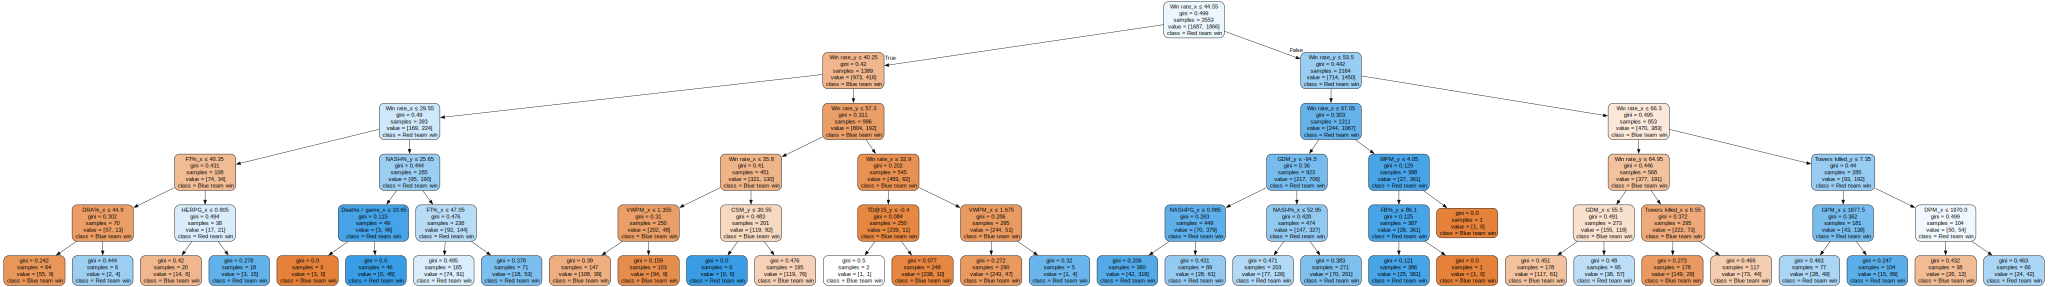

In [32]:
import graphviz

colnames = df.columns
colnames = colnames.drop("Score")

classifier = tree.DecisionTreeClassifier(max_depth=5)
classifier.fit(data, onedLabels)

dot_data = tree.export_graphviz(
    classifier,
    out_file=None,
    feature_names=colnames,
    class_names=['Blue team win','Red team win'],
    filled=True,
    rounded=True,
    special_characters=True
)

# Visualize the decision tree
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size(5,5)
pydot_graph.write_png('decisionTree.png')
graph = graphviz.Source(dot_data)
graph

Ở đây chúng ta có thể thấy những quan sát thú vị về những yếu tố quan trọng nhất để xác định người chiến thắng. Yếu tố quyết định lớn nhất tất nhiên là Win rate_x, winrate của đội xanh, giúp cắt toàn bộ tập dữ liệu thành một nửa. Sau các yếu tố dễ hiểu nhất, chúng ta sẽ thấy nhiều quan sát thú vị hơn ở độ sâu 3.

Tại độ sâu 3, chúng tôi có một số yếu tố quan trọng nhất để xác định người chiến thắng: Số trụ bị mất, Thời lượng trận đấu (trung bình của toàn bộ phần chia) và lượng sát thương trên phút (DPM). Tất nhiên, trụ và sát thương cũng có phần tự giải thích được. Đội chiến thắng luôn phá hủy được nhiều trụ hơn và thường gây ra nhiều sát thương hơn. Chỉ sau những giá trị này, chúng tôi mới có được những quan sát chuyên sâu hơn ở độ sâu 4: GDM, DRA%, TD@15, K:D cũng như số mắt được dọn sạch mỗi phút.

Ở độ sâu cuối cùng, chúng ta sẽ thấy nhiều bước phân loại thích hợp hơn. Đây là lúc để đưa ra những quyết định chặt chẽ trong một trận đấu. Ở đó chúng ta có thể thấy các giá trị như DRA@15, Kills / game, HER% và FB%.


In [33]:
predictions = classifier.predict(test_data)

accuracy = accuracy_score(test_labels, predictions)
print (f"Độ chính xác được tính từ test set = {round(accuracy * 100, 2)} %")
print (classification_report(test_labels, predictions, target_names=['Blue team win', 'Red team win']))

Độ chính xác được tính từ test set = 79.89 %
               precision    recall  f1-score   support

Blue team win       0.80      0.76      0.78       327
 Red team win       0.80      0.84      0.82       384

     accuracy                           0.80       711
    macro avg       0.80      0.80      0.80       711
 weighted avg       0.80      0.80      0.80       711



Mô hình decision tree cho kết quả trên test set khá ấn tượng là 79,89%, với một sự chênh lệch nhỏ giữa hai đội.


Tính cross-validation và vẽ confusion matrix

In [34]:
scores = cross_val_score(classifier, train_data, train_labels, cv=5)

# In ra độ chính xác trung bình và độ lệch chuẩn
print(f'Độ chính xác trung bình: {round(scores.mean()*100,2)}% (+/- {round(scores.std() * 2 * 100,2)})')

Độ chính xác trung bình: 69.95% (+/- 4.29)


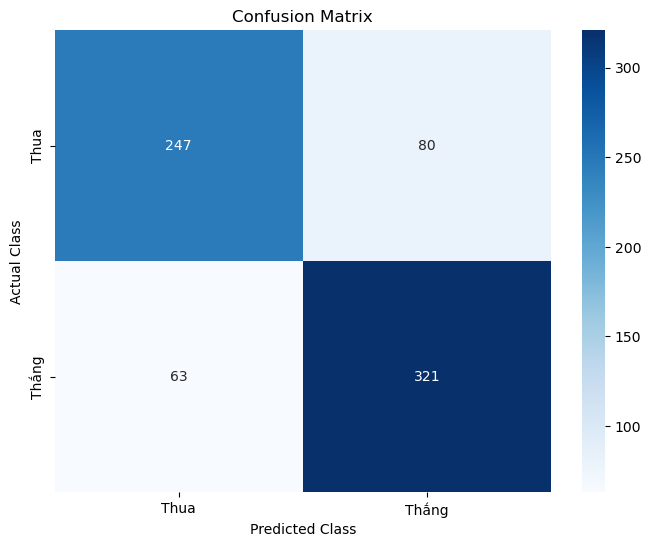

In [35]:
#Vẽ confusion matrix
draw_confusion_matrix(test_labels, predictions)

Đánh giá mô hình trên tập kiểm thử và vẽ learningcurve

In [36]:
#Đánh giá mô hình trên tập kiểm thử
eval_val_model(classifier,train_data,train_labels,validation_data,validation_labels)

Accuracy: 76.55% 		 Val Accuracy: 80.32%
Recall: 80.86% 			 Val Recall: 82.13%


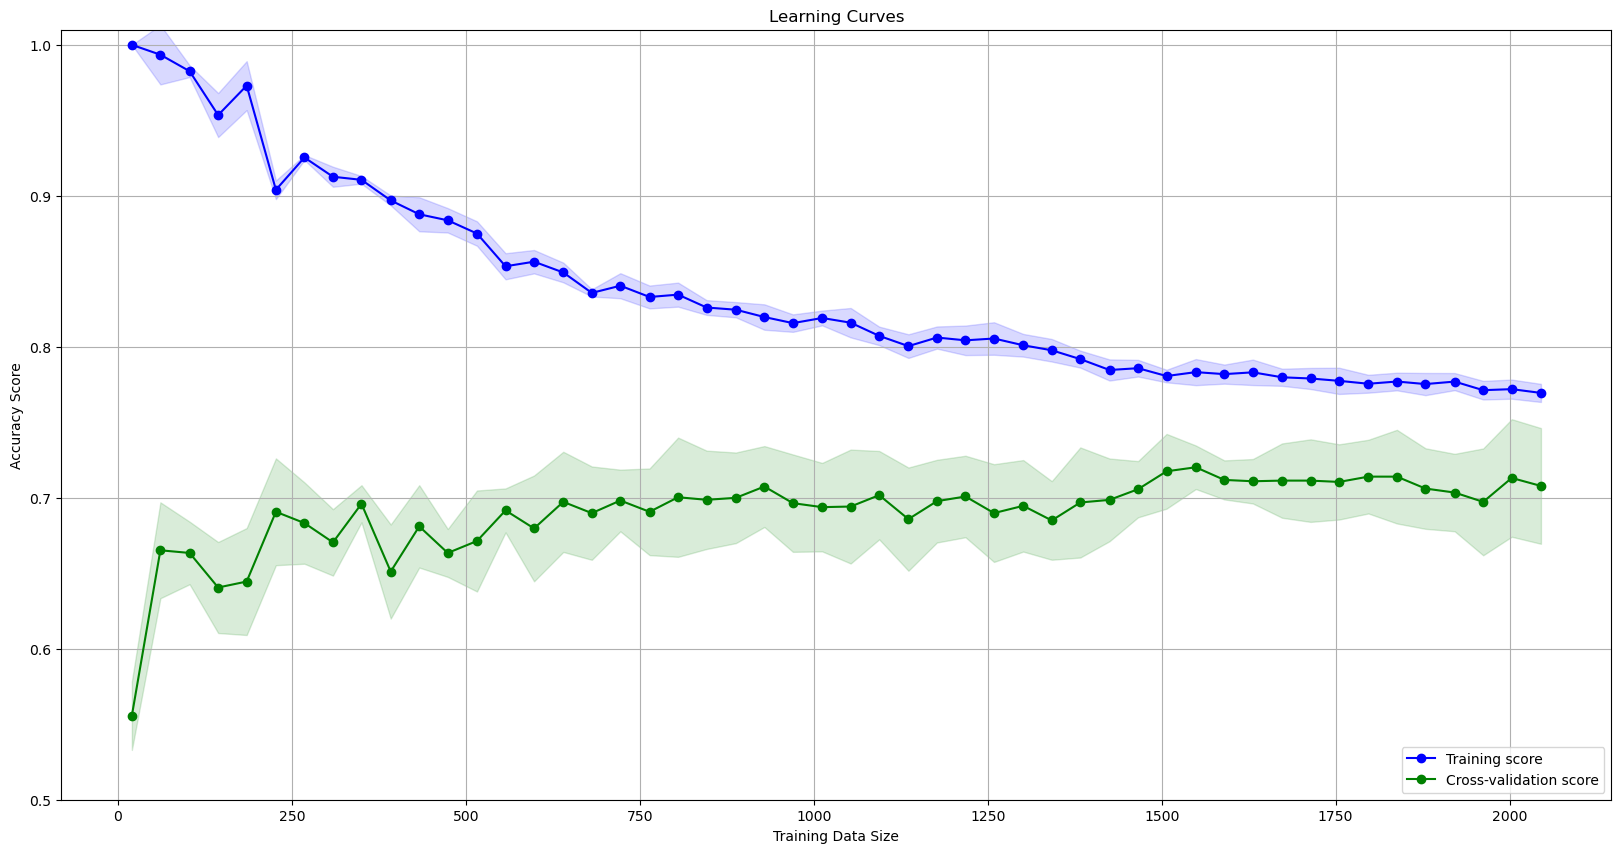

In [37]:
#Vẽ learning curve
draw_learning_curve(classifier,train_data,train_labels)

### 4.3 Logistic regression

Hồi quy logistic được sử dụng để phân loại nhị phân mà trong đó chúng ta sử dụng hàm logistic, lấy đầu vào làm biến độc lập và tạo ra giá trị xác suất từ 0 đến 1.

Chúng ta có thể xây dựng sử dụng hồi quy logistic để xây dựng mô hình dự đoán đội chiến thắng như sau:


In [38]:
# Xây dựng mô hình logistic regression
lr = LogisticRegression()
lr.fit(train_data,train_labels)


# Đánh giá mô hình trên tập kiểm thử
predictions = lr.predict(test_data)
accuracy = accuracy_score(test_labels, predictions)
print(f'Độ chính xác trên test set: {round(accuracy*100,2)}%')
print(classification_report(test_labels, predictions))

Độ chính xác trên test set: 76.51%
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       327
           1       0.78      0.79      0.78       384

    accuracy                           0.77       711
   macro avg       0.76      0.76      0.76       711
weighted avg       0.76      0.77      0.76       711



c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mô hình đạt độ chính xác 76,65% trên test set, một kết quả ổn cho việc dự đoán đội chiến thắng



Tính cross-validation và vẽ confusion matrix

In [39]:
scores = cross_val_score(lr, train_data, train_labels, cv=5)

# In ra độ chính xác trung bình và độ lệch chuẩn
print(f'Độ chính xác trung bình: {round(scores.mean()*100,2)}% (+/- {round(scores.std() * 2 * 100,2)})')

Độ chính xác trung bình: 73.38% (+/- 2.75)


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

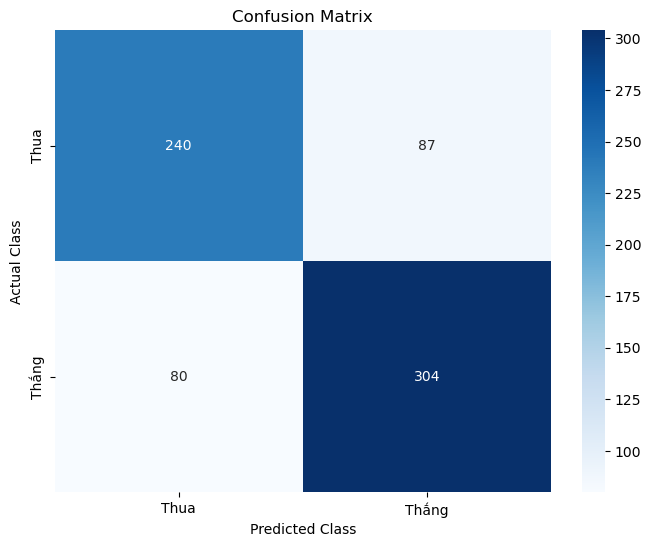

In [40]:
#Vẽ confusion matrix
draw_confusion_matrix(test_labels, predictions)

Đánh giá mô hình trên tập kiểm thử và vẽ learning curve

In [41]:
#Đánh giá mô hình trên tập kiểm thử
eval_val_model(lr,train_data,train_labels,validation_data,validation_labels)

Accuracy: 73.3% 		 Val Accuracy: 76.45%
Recall: 75.65% 			 Val Recall: 75.95%


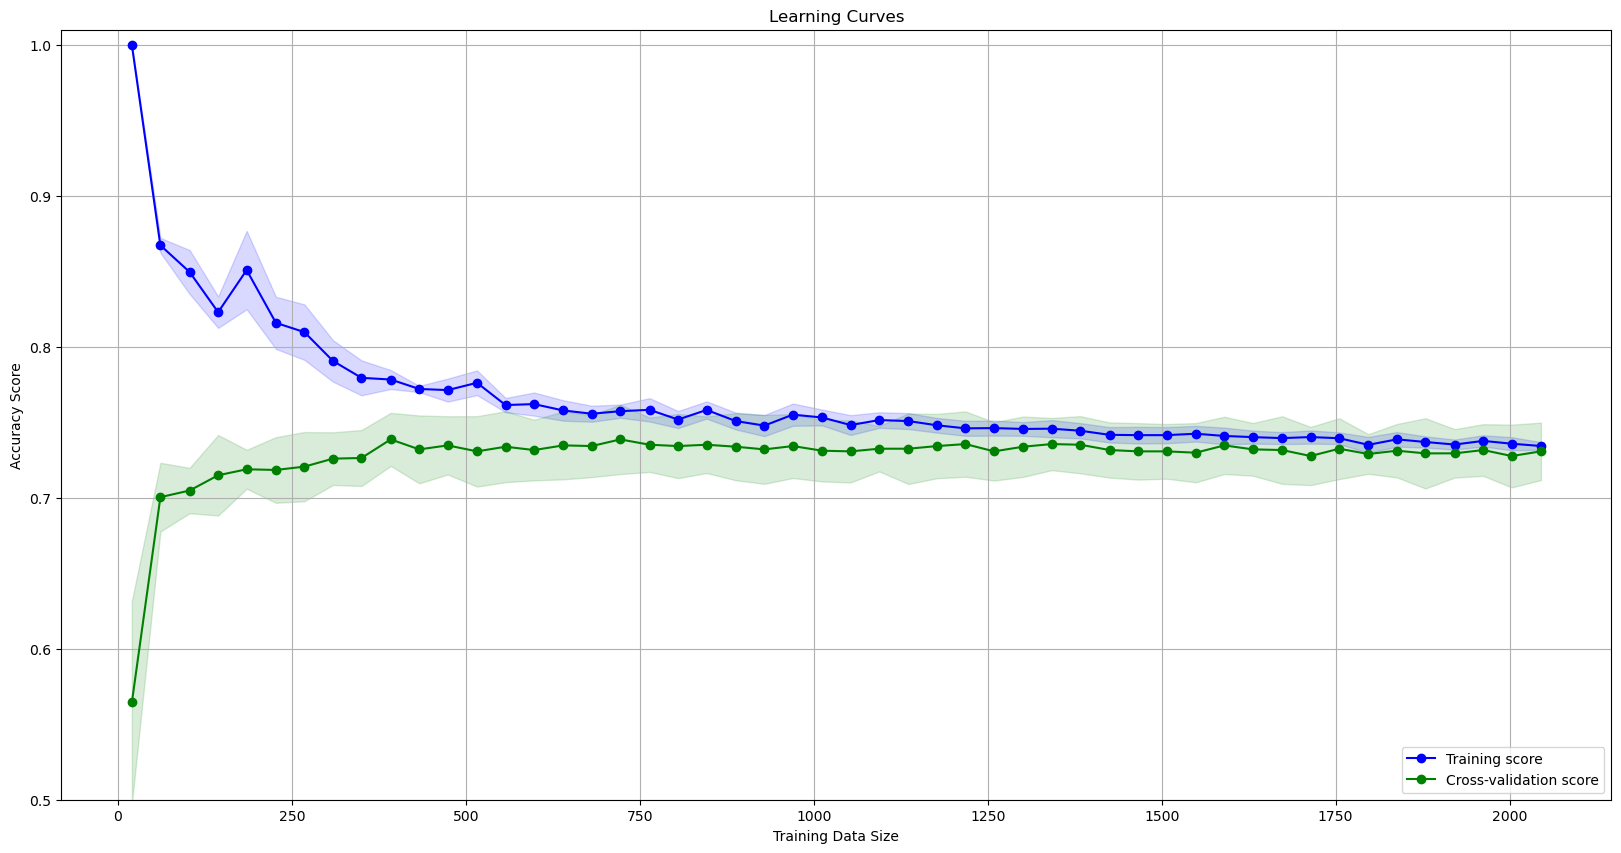

In [42]:
#Vẽ learning curve
draw_learning_curve(lr,train_data,train_labels)

Bạn cũng có thể kiểm tra các đặc trưng quan trọng trong mô hình như sau

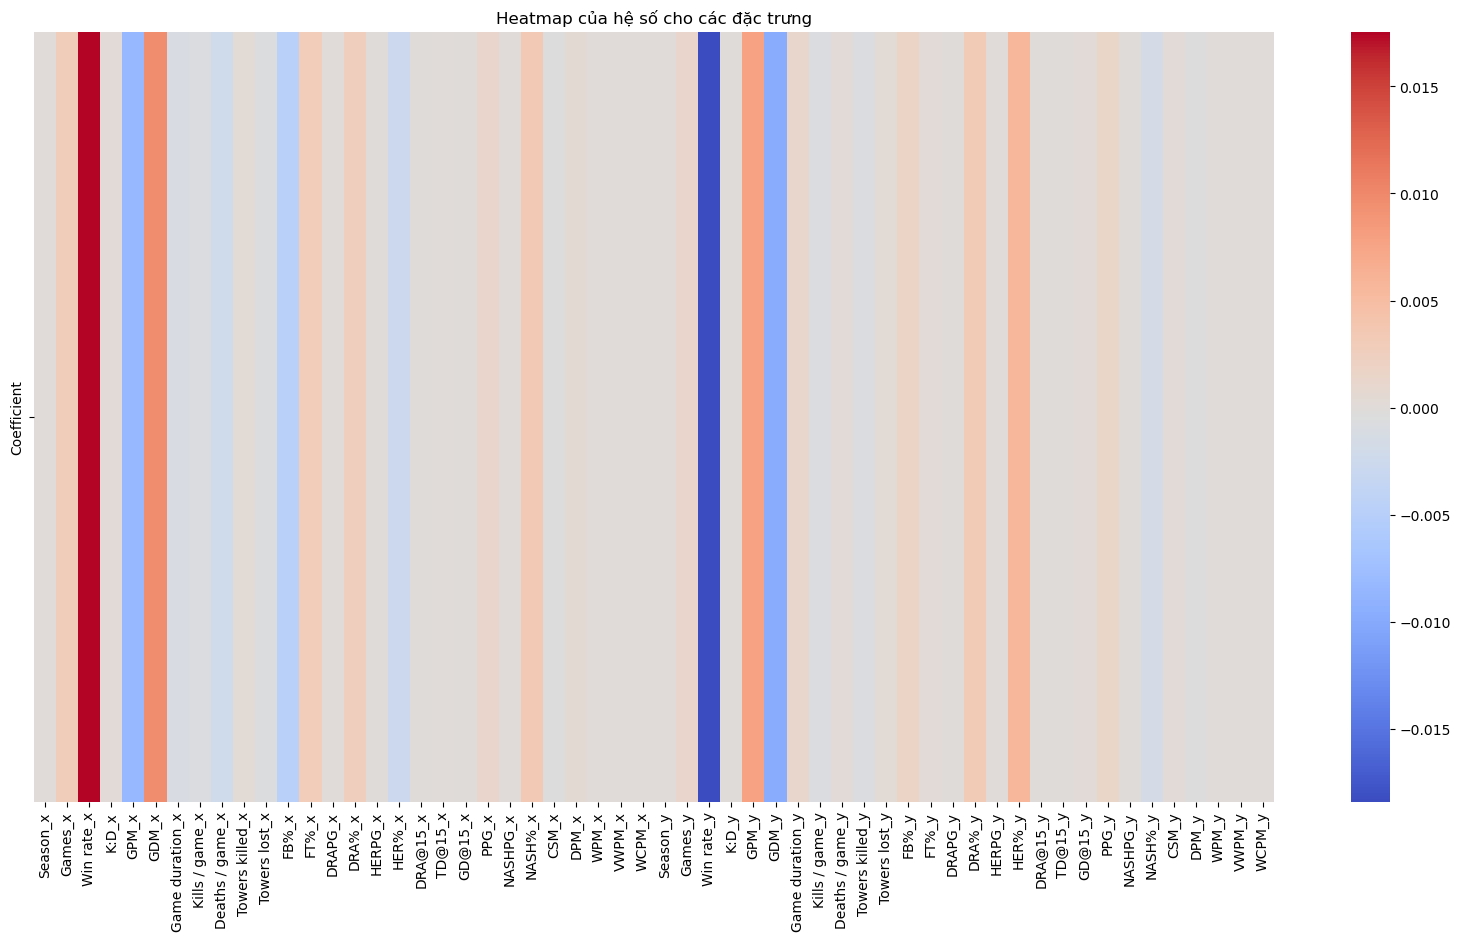

In [43]:
# Lấy ra hệ số của mô hình
coefficients = lr.coef_[0]

# Tạo DataFrame cho hệ số
coeff_df = pd.DataFrame(coefficients, index=train_data.columns, columns=['Coefficient'])

# Tạo heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(coeff_df.T,  cmap='coolwarm')
plt.title('Heatmap của hệ số cho các đặc trưng')
plt.show()

Biểu độ nhiệt cho thấy các chỉ số về Win Rate, GPM, GDM có ảnh hưởng lớn đến kết quả của trận đấu

### 4.4 Random Forest

Random Forest là một thuật toán học máy với khả năng phân loại mạnh mẽ, thuộc về kỹ thuật học có giám sát. Thuật toán này dựa trên khái niệm học tập tập thể, là quá trình kết hợp nhiều phân loại để giải quyết một vấn đề phức tạp và để cải thiện hiệu suất của mô hình.

Ta có thể xây dựng mô hinh Random Forest để dự đoán đội chiến thắng như sau:

In [44]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 5)
rf.fit(train_data, train_labels)

predictions = rf.predict(test_data)
accuracy = accuracy_score(test_labels, predictions)
print (f"Độ chính xác được tính từ test set = {round(accuracy * 100, 2)} %")
print (classification_report(test_labels, predictions, target_names=['Blue team win', 'Red team win']))

Độ chính xác được tính từ test set = 75.11 %
               precision    recall  f1-score   support

Blue team win       0.74      0.71      0.72       327
 Red team win       0.76      0.78      0.77       384

     accuracy                           0.75       711
    macro avg       0.75      0.75      0.75       711
 weighted avg       0.75      0.75      0.75       711



Tính cross-validation và vẽ confusion matrix

In [45]:
scores = cross_val_score(rf, train_data, train_labels, cv=5)

# In ra độ chính xác trung bình và độ lệch chuẩn
print(f'Độ chính xác trung bình: {round(scores.mean()*100,2)}% (+/- {round(scores.std() * 2 * 100,2)})')

Độ chính xác trung bình: 73.91% (+/- 4.32)


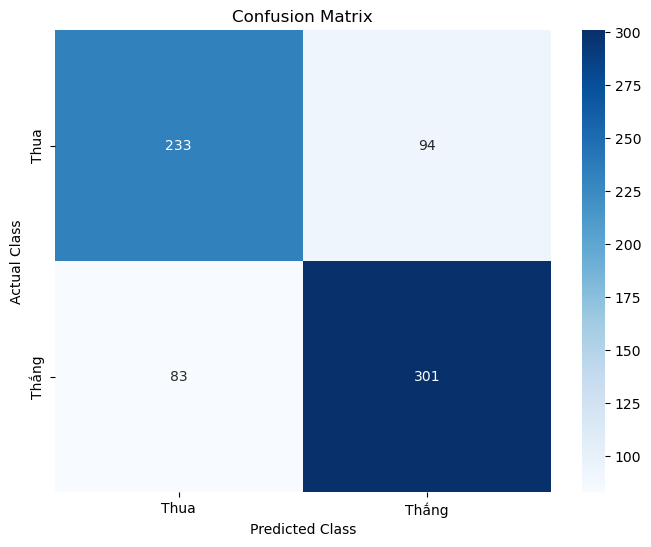

In [46]:
#Vẽ confusion matrix
draw_confusion_matrix(test_labels, predictions)

Đánh giá mô hình trên tập kiểm thử và vẽ learning curve

In [47]:
#Đánh giá mô hình trên tập kiểm thử
eval_val_model(rf, train_data, train_labels, validation_data, validation_labels)

Accuracy: 78.13% 		 Val Accuracy: 76.45%
Recall: 81.02% 			 Val Recall: 77.32%


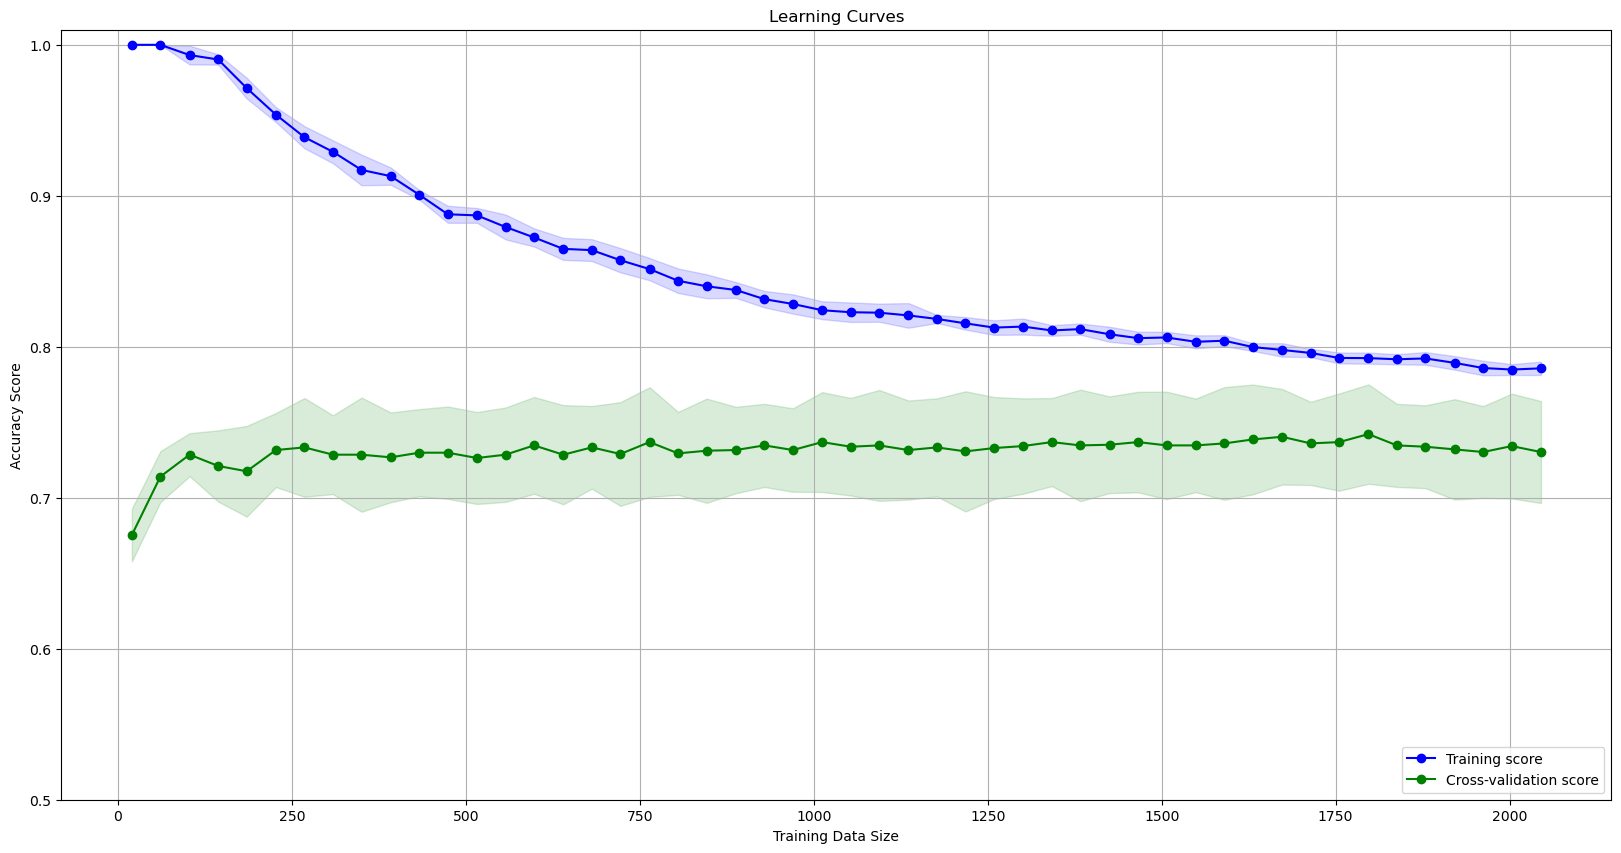

In [48]:
#Vẽ learning curve
draw_learning_curve(rf,train_data,train_labels)

Chúng ta có thể tìm hiểu về mức độ quan trọng của các đặc trưng trong mô hình

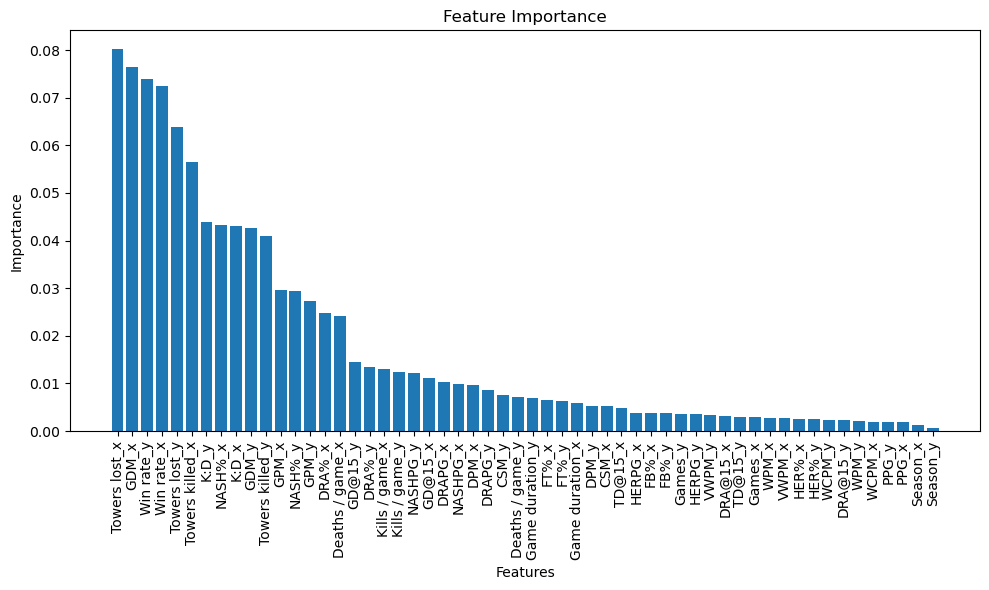

In [49]:
# Trích xuất mức độ quan trọng của các đặc trưng
importance = rf.feature_importances_

# Sắp xếp các đặc trưng theo mức độ quan trọng giảm dần
indices = np.argsort(importance)[::-1]

# Tạo danh sách tên các đặc trưng theo thứ tự quan trọng
feature_names = train_data.columns[indices]

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(train_data.shape[1]), importance[indices])
plt.xticks(range(train_data.shape[1]), feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# 5. Đánh giá các mô hình

Nhìn chung, các mô hình đều đạt kết quả khá tốt trên tập kiểm tra, giao động từ 72 đến 80%. 
Sự khác biệt giữa các chỉ số của mô hình trên tập huấn luyện và tập kiểm thử không lớn cùng với biểu đồ learning curve của các mô hình đều đang hội tụ dần cho thấy các mô hình đều đang hoạt động tốt và không có hiện tượng overfitting hay underfitting

Dưới đây là biểu đồ so sánh các hệ số đánh giá giữa các mô hình máy học đã được xây dựng để giải quyết bài toán ban đầu. Gồm có 4 giá trị: Accuracy (Độ chính xác tổng quát), Precision (Độ chính xác), Recall (Độ nhạy), F1.

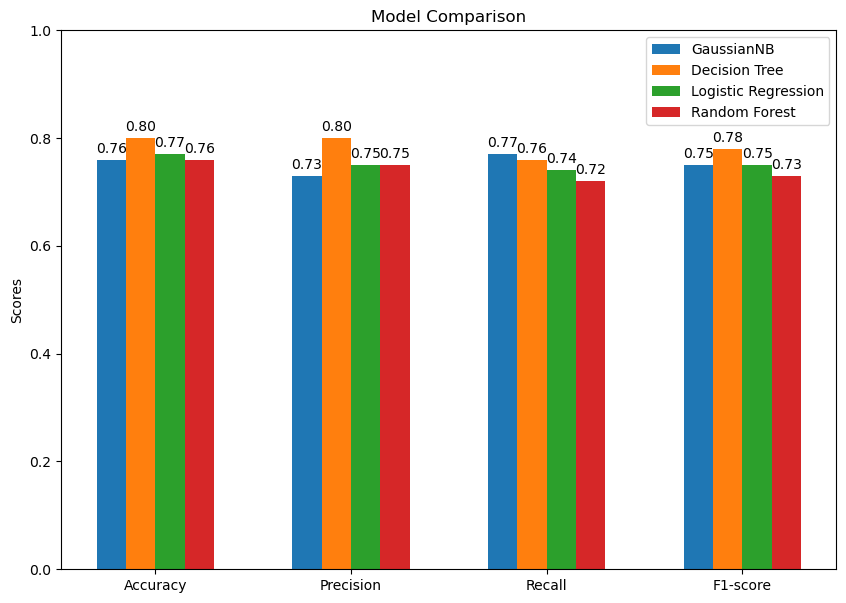

In [50]:
# Chỉ số đánh giá
labels = ["Accuracy", "Precision", "Recall", "F1-score"]
gaussianNB_scores = [0.76, 0.73, 0.77, 0.75]
decision_tree_scores = [0.80,  0.80,  0.76,  0.78]
lr_scores = [0.77, 0.75, 0.74, 0.75]
rf_scores = [0.76, 0.75, 0.72, 0.73]

x = np.arange(len(labels))
width = 0.15

# Vẽ biểu đồ cột
fig, ax = plt.subplots(figsize=(10, 7))
NB_bar = ax.bar(x - 1.5*width, gaussianNB_scores, width, label='GaussianNB')
dt_bar = ax.bar(x - 0.5*width, decision_tree_scores, width, label='Decision Tree')
lr_bar = ax.bar(x + 0.5*width, lr_scores, width, label='Logistic Regression')
rf_bar = ax.bar(x + 1.5*width, rf_scores, width, label='Random Forest')

# Định dạng biểu đồ
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hiển thị giá trị trên các cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(NB_bar)
autolabel(dt_bar)
autolabel(lr_bar)
autolabel(rf_bar)

plt.ylim(0, 1)  # Giới hạn trục y từ 0 đến 1
plt.show()

So sánh Cross-Validation Accuracy Score giữa các mô hình

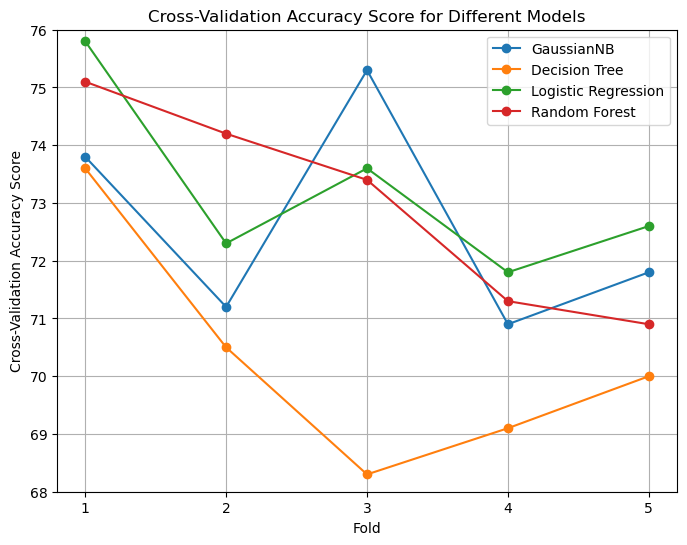

In [51]:
# Dữ liệu Cross-Validation Accuracy Score
cv_accuracy = {
   'GaussianNB': [73.8, 71.2, 75.3, 70.9, 71.8],
 'Decision Tree': [73.6, 70.5, 68.3, 69.1, 70.0],
 'Logistic Regression': [75.8, 72.3, 73.6, 71.8, 72.6],
 'Random Forest': [75.1, 74.2, 73.4, 71.3, 70.9]
}

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))

for model, scores in cv_accuracy.items():
    plt.plot(range(1, 6), scores, marker='o', linestyle='-', label=model)

plt.xlabel('Fold')
plt.ylabel('Cross-Validation Accuracy Score')
plt.title('Cross-Validation Accuracy Score for Different Models')
plt.xticks(np.arange(1, 6))
plt.ylim(68, 76)
plt.legend()
plt.grid(True)
plt.show()

Accuracy: Mô hình Decision Tree có điểm số cao nhất với khoảng 0.80, tiếp theo là Logistic Regression (0.77) ,cuối cùng là GaussianNB và Random Forest với số điểm bằng nhau (0.76). Tuy nhiên, sự khác biệt giữa các mô hình không lớn.

Precision: Mô hình Decision Tree có độ chính xác (precision) cao nhất với khoảng 0.8, tiếp theo là Logistic Regression và Random Forest (0.75), cuối cùng là GaussianNB (0.73)

Recall: Mô hình GaussianNB có khả năng phát hiện các dữ liệu positive (recall) cao nhất với khoảng 0.77, tiếp theo là Decision Tree (0.76), Logistic Regression (0.74) và Random Forest (0.72).

F1-score: Mô hình Decision Tree có F1-score cao nhất với khoảng 0.78, tiếp theo là GaussianNB và Logistic Regression (0.75),và Random Forest (0.73)

Decision Tree có vẻ có hiệu suất tốt nhất với các chỉ số Accuracy, Precision và F1-score cao nhất trong số các mô hình. Do đó, nếu bạn muốn chọn một mô hình duy nhất, có thể xem xét mô hình Decision Tree như một lựa chọn tiềm năng. Tuy nhiên, cần xem xét kỹ càng và điều chỉnh các siêu tham số của mô hình để đạt hiệu suất tốt nhất trong bối cảnh cụ thể của bài toán của bạn.

# 6. Kết luận

Với dữ liệu được chuẩn bị, sau khi thực hiện tiền xử lý dữ liệu, tối ưu lại dữ liệu thì đã xây dựng được mô hình dự đoán duy trì độ chính xác trung bình là 72% và có thể đạt tới 80%. Đây là một kết quả ấn tượng với một mô hình dự đoán

Tuy nhiên với sự khắc nghiệt của các giải đấu LOL nơi mà bất cứ kịch bản nào cũng có thể xảy ra thì 1 đội bóng được đánh giá thấp hơn cũng có thể có được chiến thắng. Bên cạnh đó còn có những yếu tố về con người, môi trường có thể ảnh hưởng đến kết quả của trận đấu. Đó cũng chính là vấn đề mà mô hình dự đoán này gặp phải.

Những việc sẽ được làm tiếp theo để cải thiện mô hình dự đoán
- Thu thập thêm nhiều dữ liệu của nhiều mùa trước đó
- Dùng thêm nhiều phương pháp khác nhau để giải quyết
- Tìm thêm các đặc trưng ảnh hưởng đến kết quả dự đoán